# <code>aca_l0</code> tests #

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
import astropy.units as u
from mica.archive import aca_l0
import Ska.engarchive.fetch as fetch
import numpy.ma as ma
from chandra_aca import transform
from kadi import events
from Ska.Matplotlib import plot_cxctime

### 1. Preparation ###

* <code>aca_l0</code> : pixel value to mag, compare with <code>aoacmag</code>

* Simulate dither

* Simulate a gaussian star

### <code>aca_l0</code> : pixel value to mag, compare with <code>aoacmag</code> ###

In [2]:
obsid = 50804
slot = 3
dwell = events.dwells.filter(obsid=obsid)[0]
slot_data = aca_l0.get_slot_data(dwell.start, dwell.stop, slot=slot)

imgraw = slot_data['IMGRAW']
time = slot_data['TIME']
bgdavg = slot_data['BGDAVG']
integ = slot_data['INTEG']
col0 = slot_data['IMGCOL0']
row0 = slot_data['IMGROW0']

In [3]:
# subtract average background
imgsub = [img - bgd for img, bgd in zip(imgraw, bgdavg)]
imgsub = [img.reshape(8, 8) for img in imgsub]

In [4]:
print imgsub[0]

[[6.0 7.0 -2.0 -7.0 74.0 -5.0 -3.0 -4.0]
 [-7.0 -10.0 19.0 -6.0 -3.0 4.0 -5.0 -3.0]
 [-3.0 -7.0 98.0 66.0 35.0 29.0 -5.0 26.0]
 [-7.0 75.0 261.0 466.0 423.0 110.0 37.0 51.0]
 [-3.0 25.0 530.0 328.0 484.0 254.0 15.0 -8.0]
 [-7.0 20.0 113.0 270.0 417.0 154.0 6.0 16.0]
 [90.0 -5.0 3.0 133.0 104.0 9.0 9.0 12.0]
 [13.0 -13.0 101.0 6.0 -5.0 -3.0 -7.0 -1.0]]


In [6]:
# zero 6x6 corners
def zero_6x6_corners(img, centered=True): # img is a 8x8 array
    if not img.shape == (8, 8):
        raise Exception("Img should be a 8x8 array")
    if centered:
        r4 = [1, 1, 6, 6]
        c4 = [1, 6, 1, 6]
    else:
        r4 = [0, 0, 5, 5]
        c4 = [0, 5, 0, 5]
    for rr, cc in zip(r4, c4):
        img[rr][cc] = 0.0
    return img


for img in imgsub:
    img = zero_6x6_corners(img, centered=True)
    
print imgsub[0]

[[6.0 7.0 -2.0 -7.0 74.0 -5.0 -3.0 -4.0]
 [-7.0 0.0 19.0 -6.0 -3.0 4.0 0.0 -3.0]
 [-3.0 -7.0 98.0 66.0 35.0 29.0 -5.0 26.0]
 [-7.0 75.0 261.0 466.0 423.0 110.0 37.0 51.0]
 [-3.0 25.0 530.0 328.0 484.0 254.0 15.0 -8.0]
 [-7.0 20.0 113.0 270.0 417.0 154.0 6.0 16.0]
 [90.0 0.0 3.0 133.0 104.0 9.0 0.0 12.0]
 [13.0 -13.0 101.0 6.0 -5.0 -3.0 -7.0 -1.0]]


In [7]:
gain = 5.
mag = [transform.count_rate_to_mag(img[1:7][1:7].sum() * gain / integ[0]) for img in imgsub]
print np.median(mag)
print mag[0]

9.25133491798
9.28761808229


In [8]:
print imgsub[0][1:7][1:7].sum()

cr = integ[0] * transform.mag_to_count_rate(mag[0]) / gain
print cr

4620.0
4620.0


Telemetry  3107
Level0  777


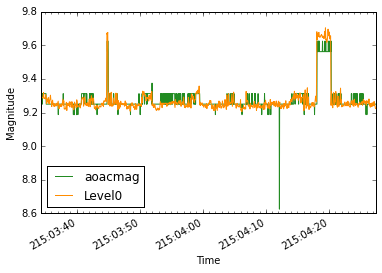

In [10]:
# Magnitude from telemetry
telem = fetch.MSID('aoacmag{}'.format(slot), start=dwell.start, stop=dwell.stop)
plot_cxctime(telem.times, telem.vals, label='aoacmag', color='forestgreen')
print 'Telemetry ', len(telem.times)

# Magnitude computed by dorectly integrating the aca_l0 pixel values
plot_cxctime(time, mag, label='Level0', color='darkorange')
print 'Level0 ', len(time)

plt.legend(loc='lower left')
plt.xlabel('Time')
plt.ylabel('Magnitude')

### Simulate dither ###

In [11]:
# Dither parameters
ampl = 8. * u.arcsec
pxsize = 5. * u.arcsec # per pixel
pitch_period = 707.1 # sec
yaw_period = 1000.0 # sec
delta_pitch = 300. # sec
delta_yaw = 100. # sec

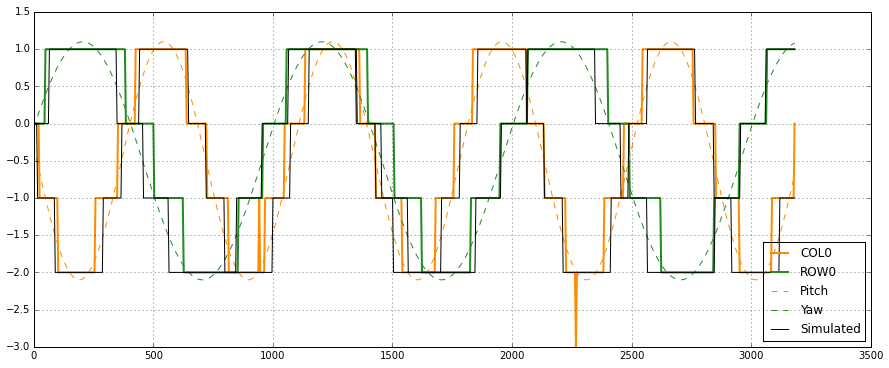

In [21]:
pitch = ampl / pxsize * np.sin(2 * np.pi * time / pitch_period + delta_pitch) - 0.5
yaw = ampl / pxsize * np.sin(2 * np.pi * time / yaw_period + delta_yaw) - 0.5

plt.figure(figsize=(15, 6))

plt.plot(time - time[0], col0 - col0[0], 'darkorange', lw=2, label='COL0')
plt.plot(time - time[0], row0 - row0[0], 'forestgreen', lw=2, label='ROW0')
plt.plot(time - time[0], pitch, 'darkorange', ls='--', label='Pitch')
plt.plot(time - time[0], yaw, 'forestgreen', ls='--', label='Yaw')
plt.grid()

plt.plot(time - time[0], np.rint(pitch), 'k', label='Simulated')
plt.plot(time - time[0], np.rint(yaw), 'k')
plt.legend(loc='lower right')

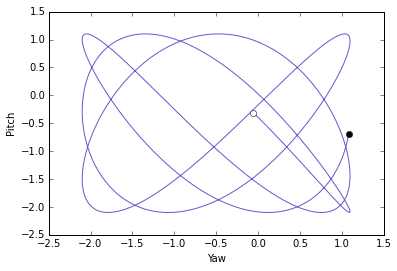

In [22]:
plt.plot(yaw[:2000], pitch[:2000], 'slateblue')
plt.xlabel("Yaw")
plt.ylabel("Pitch")
plt.plot(yaw[0], pitch[0], 'o', color='white')
plt.plot(yaw[-1], pitch[-1], 'o', color='black')

### Simulate a gaussian star ###

In [23]:
# 2-d Gaussian star with magnitude mag and FWHM, noise: gaussian
def simulate_star(img_size, fwhm, mag, integ, bgd=None, roff=0, coff=0):
    
    if img_size not in [6, 8]:
        raise Exception('Expecting img_size = 6 or 8 (pixels)')
        
    if not isinstance(bgd, (np.int, np.float, np.ndarray)) or np.shape(bgd) not in [(), (8, 8), (64,)]:
        raise Exception('bgd expected to be int, float or (8, 8) or (64,) array')
    
    star = np.zeros((img_size, img_size))

    # Mag to counts conversion
    gain = 5. # e-/ADU
    counts = integ * transform.mag_to_count_rate(mag) / gain

    # Gaussian model
    halfsize = np.int(img_size / 2)
    row, col = np.mgrid[-halfsize:halfsize, -halfsize:halfsize] + 0.5
    sigma = fwhm / (2. * np.sqrt(2. * np.log(2.)))
    g = np.exp(-((row - roff)**2  / sigma**2 + (col - coff)**2 / sigma**2) / 2.)
    
    # Zero 6x6 corners
    #g = zero_6x6_corners(g, centered=True)
    
    # Normalize to counts
    i1 = np.int(halfsize + 0.5 - 3)
    i2 = np.int(halfsize + 0.5 + 3)
    g = counts * g / g[i1:i2][i1:i2].sum()    

    # Simulate star
    star = np.random.normal(g)
        
    # Add background
    if bgd == 0:
        bgd = np.zeros((8, 8))
    if np.shape(bgd) == () and bgd > 0:
        bgd = np.random.normal(bgd, np.sqrt(bgd), 64).reshape(8, 8)
    if np.shape(bgd) == 64:
        bgd = bgd.reshape(8, 8)
    #bgd = zero_6x6_corners(bgd, centered=True)

    star = star + bgd

    star = np.rint(star)
    
    return star

In [24]:
c32 = np.array([1, 2, 2, 6, 6, 7, 7, 6, 6, 2, 2, 1, 1]) - 0.5
r32 = np.array([2, 2, 1, 1, 2, 2, 6, 6, 7, 7, 6, 6, 2]) - 0.5

c6x6 = [0.5, 6.5, 6.5, 0.5, 0.5]
r6x6 = [0.5, 0.5, 6.5, 6.5, 0.5]

def plot_star_image(data):
    plt.imshow(data, cmap=plt.get_cmap('jet'), interpolation='none', origin='lower')
    plt.colorbar()
    plt.plot(c32, r32, '--', lw=2, color='w')
    plt.plot(c6x6, r6x6 , '-', lw=2, color='w')
    plt.xlim(-0.5, 7.5)
    plt.ylim(-0.5, 7.5)
    return

In [25]:
roff = 2
coff = 0
fwhm = 1.8
mag = 10.2
integ = 1.696
imgsize = 8
bgdavg = 10
star_img = simulate_star(imgsize, fwhm, mag, integ, bgdavg, roff=roff, coff=coff)

10.0077806414
10.2075600584


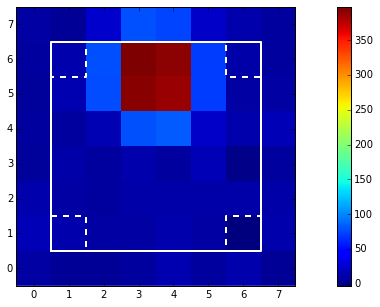

In [26]:
plt.figure(figsize=(15, 5))

plot_star_image(star_img)

mag1 = transform.count_rate_to_mag(star_img[1:7][1:7].sum() * 5 / integ)
mag2 = transform.count_rate_to_mag((star_img[1:7][1:7] - bgdavg).sum() * 5 / integ)
print mag1
print mag2

### 2. Simulate telemetry in <code>aca_l0</code> format ###

In [31]:
def simulate_aca_l0(img_size, nframes, delta_t, integ, \
                    bgdavg=None, fwhm=1.8, mag=10.2, phase=0, roff=0, coff=0):

    t_end = nframes * delta_t - delta_t
    times = np.arange(0, t_end, delta_t) 

    # define dither to get imgrow0, imgcol0
    ampl = 8. * u.arcsec
    pxsize = 5. * u.arcsec # per pixel
    pitch_period = 707.1 # sec
    yaw_period = 1000.0 # sec
    delta_pitch = 0. # sec
    delta_yaw = delta_pitch + phase # sec

    pitch = ampl / pxsize * np.sin(2 * np.pi * times / pitch_period + delta_pitch) - 0.5 # col0
    yaw = ampl / pxsize * np.sin(2 * np.pi * times / yaw_period + delta_yaw) - 0.5 # row0

    col0 = np.rint(pitch)
    row0 = np.rint(yaw)
    
    data = []
    img_size2 = img_size * img_size
    
    for i, time in enumerate(times):
        imgraw = simulate_star(img_size, fwhm, mag, integ, bgdavg, roff=roff, coff=coff)
        imgraw = imgraw.reshape(1, img_size2)[0]
        mask = img_size2 * [0]
        fill_value = 1.e20
        imgraw = ma.array(data=imgraw, mask=mask, fill_value=fill_value)
        
        data_row = (time, imgraw, row0[i], col0[i], bgdavg, img_size)
        data.append(data_row)
        
    data = np.ma.array(data, dtype=[('TIME', '>f8'), ('IMGRAW', '>f4', (64,)),
                                    ('IMGROW0', '>i2'), ('IMGCOL0', '>i2'),
                                    ('BGDAVG', '>i2'), ('IMGSIZE', '>i4')])

    return data

In [32]:
imgsize = 8
nframes = 1000
delta_t = 4.1
integ = 1.696
bgdavg = 0.

slot_data = simulate_aca_l0(imgsize, nframes, delta_t, integ, bgdavg)

In [33]:
t = Table(slot_data)

In [34]:
print t.colnames

['TIME', 'IMGRAW', 'IMGROW0', 'IMGCOL0', 'BGDAVG', 'IMGSIZE']
